# Sentimental Tweets Videos Games

L'objectif principal de ce projet est de déterminer si un type de jeu est perçu comme bon, mauvais ou neutre à partir d'un ensemble de tweets, en utilisant des modèles de traitement du langage naturel (NLP) ou de Machine Learning. <br>

Dans un premier temps, nous allons explorer et analyser le jeu de données pour mieux comprendre sa structure. Cela inclura des étapes de prétraitement des données visant à nettoyer les valeurs manquantes, éliminer les doublons et améliorer la qualité du contenu des tweets afin de mieux représenter le corpus. <br>

Ensuite, nous utiliserons une méthode de pondération des mots appelée TF-IDF (Term Frequency-Inverse Document Frequency). Cette méthode permettra d'identifier la fréquence des mots et leur importance relative pour chaque tweet. <br>

Une fois les données préparées, nous entraînerons différents modèles de Machine Learning à l'aide de la bibliothèque Scikit-learn. Ces modèles seront évalués pour identifier les plus performants à l'aide de techniques de validation croisée. <br>

Enfin, nous validerons les performances du modèle sélectionné sur un jeu de données différent. <br>

Par ailleurs, nous explorerons des outils d'interprétabilité pour analyser les prédictions du modèle. Cela nous permettra de comprendre et d'identifier les erreurs, que ce soit sur le jeu d'entraînement ou le jeu de test. <br>

https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis (Lien de téléchargement de deux datasets) <br>

## Load librairies

*Commande pour installer toute les librairies*

!pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt_tab')
nltk.download('stopwords')

from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import randint

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lecture et exploration du dataset

Le jeu de données utilisé se compose de 4 types de colonnes : <br>

L'index de la catégorie <br>
La catégorie du jeu <br>
La catégorie du sentiment <br>
Le contenu du tweet <br>

#### Phase de Nettoyage des tweets

On va supprimer la colonne l'index de la catégorie qui nous serve pas pour le moment et puis de supprimer tout les valeurs manquants, les doublons
et de retirer tout les catégories qui ne provient pas les catégories sur les jeux vidéos...

Au total, on utilise 74000 de lignes de données à traiter et à la fin on aura environ 40000 lignes de données à traiter après le nettoyage

In [2]:
data_path = "data"

In [3]:
df = pd.read_csv(f"{data_path}/twitter_training.csv",names=["index_category", "game_category","sentiment_category","Tweet"])
df_val = pd.read_csv(f"{data_path}/twitter_validation.csv",names=["index_category", "game_category","sentiment_category","Tweet"])

In [4]:
df.head()

,index_category,game_category,sentiment_category,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
df_val.head()

,index_category,game_category,sentiment_category,Tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index_category      74682 non-null  int64 
 1   game_category       74682 non-null  object
 2   sentiment_category  74682 non-null  object
 3   Tweet               73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index_category      1000 non-null   int64 
 1   game_category       1000 non-null   object
 2   sentiment_category  1000 non-null   object
 3   Tweet               1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [8]:
df["sentiment_category"].describe()

count        74682
unique           4
top       Negative
freq         22542
Name: sentiment_category, dtype: object

In [9]:
df_val["sentiment_category"].describe()

count        1000
unique          4
top       Neutral
freq          285
Name: sentiment_category, dtype: object

In [10]:
print("Taille de données restant pour le jeu d'entrainement:", df.shape)
print("Taille de données restant pour le jeu de validation:", df_val.shape)

Taille de données restant pour le jeu d'entrainement: (74682, 4)
Taille de données restant pour le jeu de validation: (1000, 4)


On supprime l'index_category la colonne qui nous serve pas pour le moment

In [11]:
df = df.drop(columns='index_category',axis=1)
df_val = df_val.drop(columns='index_category',axis=1)

In [12]:
df.head()

,game_category,sentiment_category,Tweet
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [13]:
df_val.head()

,game_category,sentiment_category,Tweet
0,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Google,Neutral,Now the President is slapping Americans in the...


On observe qu'il y a 686 de valeurs manquants sur le Tweet  0 valeur manquants sur le jeu de test 

In [14]:
print(f"Valeurs manquants sur le jeu d'entrainement:")
print(df.isnull().sum())
print("Valeurs manquants sur le jeu de test:")
print(df_val.isnull().sum())

Valeurs manquants sur le jeu d'entrainement:
game_category           0
sentiment_category      0
Tweet                 686
dtype: int64
Valeurs manquants sur le jeu de test:
game_category         0
sentiment_category    0
Tweet                 0
dtype: int64


In [15]:
print("Avant la suppression des données manquantes: ",len(df))
df = df.dropna()
print("Après la suppression des données manquantes: ",len(df))

Avant la suppression des données manquantes:  74682
Après la suppression des données manquantes:  73996


### Retirer les doublons

In [16]:
df = df.drop_duplicates()
df_val = df_val.drop_duplicates()
print("Taille de données restant pour le jeu d'entrainement:", df.shape)
print("Taille de données restant pour le jeu de validation:", df_val.shape)

Taille de données restant pour le jeu d'entrainement: (70958, 3)
Taille de données restant pour le jeu de validation: (1000, 3)


Retirer les catégories qui sont exclues aux noms des jeux vidéos

In [17]:
exclude_categories = ['johnson&johnson', 'Amazon','Nvidia','PlayStation5(PS5)','Xbox(Xseries)','HomeDepot','Verizon','Facebook','Google','Microsoft']

df = df[~df['game_category'].isin(exclude_categories)]
df_val = df_val[~df_val['game_category'].isin(exclude_categories)]

Retirer la catégorie Irrelevant (car il y a pas assez de données pour effectuer l'analyse des sentiments) <br>
On se base uniquement sur 3 catégories sentiments (positive, négative et neutre)

In [18]:
df = df[df['sentiment_category'] != 'Irrelevant']
df_val = df_val[df_val['sentiment_category'] != 'Irrelevant']

all_sentiments = df['sentiment_category'].unique()
all_sentiments_val = df_val['sentiment_category'].unique()

print("Liste des catégories sentiments jeu d'entrainement ",all_sentiments)
print("Liste des catégories sentiments jeu de validation ",all_sentiments_val)

Liste des catégories sentiments jeu d'entrainement  ['Positive' 'Neutral' 'Negative']
Liste des catégories sentiments jeu de validation  ['Negative' 'Positive' 'Neutral']


In [19]:
print("Taille de données restant pour le jeu d'entrainement:", df.shape)
print("Taille de données restant pour le jeu de validation:", df_val.shape)

Taille de données restant pour le jeu d'entrainement: (39588, 3)
Taille de données restant pour le jeu de validation: (567, 3)


In [20]:
df.head()

,game_category,sentiment_category,Tweet
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [21]:
df_val.head()

,game_category,sentiment_category,Tweet
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
5,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
6,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
7,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ..."
8,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...


## Premiers Visualisations à interpréter

### Liste des noms de jeux

Voici la liste des catégories des jeux utilisés pour notre jeu de données, on a exactement les mêmes types de jeux qu'on va utiliser pour le jeu d'entrainement et pour la validation

In [22]:
all_games_category = df['game_category'].unique()
all_games_category_val = df_val['game_category'].unique()

In [23]:
print("Liste des jeux du jeu d'entrainement:",all_games_category)
print("Total des jeux:",len(all_games_category))

Liste des jeux du jeu d'entrainement: ['Borderlands' 'CallOfDutyBlackopsColdWar' 'Overwatch' 'NBA2K' 'Dota2'
 'WorldOfCraft' 'CS-GO' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'FIFA' 'RedDeadRedemption(RDR)'
 'CallOfDuty' 'TomClancysRainbowSix' 'GrandTheftAuto(GTA)' 'MaddenNFL'
 'Cyberpunk2077' 'TomClancysGhostRecon']
Total des jeux: 22


In [24]:
print("Liste des jeux du jeu de test:",all_games_category_val)
print("Total des jeux:",len(all_games_category))

Liste des jeux du jeu de test: ['CS-GO' 'FIFA' 'MaddenNFL' 'TomClancysRainbowSix' 'AssassinsCreed'
 'CallOfDuty' 'Dota2' 'NBA2K' 'GrandTheftAuto(GTA)'
 'RedDeadRedemption(RDR)' 'Hearthstone' 'ApexLegends' 'Borderlands'
 'Fortnite' 'Overwatch' 'CallOfDutyBlackopsColdWar'
 'PlayerUnknownsBattlegrounds(PUBG)' 'TomClancysGhostRecon' 'WorldOfCraft'
 'LeagueOfLegends' 'Cyberpunk2077' 'Battlefield']
Total des jeux: 22


Répartition des jeux par catégorie sur l'ensemble des tweets 

In [25]:
counts_games = df['game_category'].value_counts().sort_index()
counts_games_val = df_val['game_category'].value_counts().sort_index()

counts_games_df = counts_games.reset_index()
counts_games_df.columns = ['game_category', 'count']

counts_games_val_df = counts_games_val.reset_index()
counts_games_val_df.columns = ['game_category', 'count']

# Fusion des deux DataFrames pour un affichage combiné
combined_df = counts_games_df.merge(counts_games_val_df, on='game_category', how='outer', suffixes=('_train', '_val'))

# Création du graphique en barres empilées
fig = px.bar(
    combined_df,
    x='game_category',
    y=['count_train', 'count_val'],
    title='Répartition des jeux par catégorie (barres empilées)',
    labels={'value': 'Nombre de tweets', 'variable': 'Type de jeu', 'game_category': 'Catégorie de jeu'},
    barmode='stack',  # Utilisation de barres empilées
    text_auto=True  # Affiche les valeurs directement sur les barres
)

# Amélioration de l'apparence
fig.update_layout(
    xaxis_tickangle=-45,
    width=1250,
    height=650,
    legend_title_text='Type de jeu'  # Titre pour la légende
)

fig.show()

In [26]:
sentiment_percentage_train = df['sentiment_category'].value_counts(normalize=True) * 100
sentiment_percentage_val = df_val['sentiment_category'].value_counts(normalize=True) * 100

percentage_train_df = pd.DataFrame({'Sentiment': sentiment_percentage_train.index, 'Percentage': sentiment_percentage_train.values})
percentage_val_df = pd.DataFrame({'Sentiment': sentiment_percentage_val.index, 'Percentage': sentiment_percentage_val.values})

combined_sentiment_df = percentage_train_df.merge(percentage_val_df, on='Sentiment', how='outer', suffixes=('_train', '_val'))

# Création du graphique en barres empilées
fig = px.bar(
    combined_sentiment_df,
    x='Sentiment',
    y=['Percentage_train', 'Percentage_val'],
    title="Percentage of Each Sentiment Class (Train vs Validation)",
    labels={'value': 'Percentage (%)', 'variable': 'Dataset', 'Sentiment': 'Sentiment Class'},
    barmode='stack',  # Utilisation de barres empilées
    text_auto='.2f'  # Affiche les pourcentages avec deux décimales
)

# Amélioration de l'apparence
fig.update_layout(
    width=600,
    height=500,
    legend_title_text='Dataset'  # Titre pour la légende
)

fig.show()

### Répartition du nombre de caractères utilisés selon les sentiments positifs, négatifs ou neutres dans le jeu d'entraînement.

In [27]:
positive_df = df[df.sentiment_category == "Positive"].copy()
negatif_df = df[df.sentiment_category == "Negative"].copy()
neutral_df = df[df.sentiment_category == "Neutral"].copy()

positive_df["nb_char"] = positive_df["Tweet"].apply(len)
negatif_df["nb_char"] = negatif_df["Tweet"].apply(len)
neutral_df["nb_char"] = neutral_df["Tweet"].apply(len)

In [28]:
fig_hist_pos = px.histogram(positive_df, x="nb_char", title="Répartition du nombre de caractères dans les textes positifs")
fig_hist_pos.update_layout(width=800, height=500)

In [29]:
fig_hist_neg = px.histogram(negatif_df, x="nb_char", title="Répartition du nombre de caractères dans les textes négatives")
fig_hist_neg.update_layout(width=800, height=500)

In [30]:
fig_hist_neu = px.histogram(neutral_df, x="nb_char", title="Répartition du nombre de caractères dans les textes neutres")
fig_hist_neu.update_layout(width=600, height=500)

### Coefficient de Gini<br>
 
Les sentiments sont-ils bien répartis entre les différentes catégories ? <br>
Y a-t-il une forte concentration dans une ou deux catégories spécifiques ? <br>

Si le coefficient de Gini est proche de 0, cela signifie que les sentiments sont assez équilibrés entre les différentes catégories (positif, neutre, négatif). <br>
Si le coefficient de Gini est proche de 1, cela signifie qu'il y a une grande concentration des sentiments dans une seule catégorie, et les autres sont peu représentées. <br>


In [31]:
# Fonction pour calculer le coefficient de Gini
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

# Dataset pour la répartition des sentiments de chaque tweet
percentages = df['sentiment_category'].value_counts(normalize=True)
percentages_val = df_val['sentiment_category'].value_counts(normalize=True)

# Calcul du coefficient de Gini
gini_coef = gini(percentages)
gini_coef_val = gini(percentages_val)
print("Coefficient de Gini de l'entrainement :", round(gini_coef,2))
print("Coefficient de Gini pour la validation :", round(gini_coef_val,2))

Coefficient de Gini de l'entrainement : 0.08
Coefficient de Gini pour la validation : 0.03


### Data preprocessing

In [32]:
english_stopwords = set(stopwords.words('english'))

def remove_emoji():
  regex_pattern = re.compile(pattern = "["    #Pattern pour enlever les emojis
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642" 
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
                            "]+", flags = re.UNICODE)
  return regex_pattern

def lematize(text):
  lemmatizer = WordNetLemmatizer()
  return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


def clean_text(text):
    
    """
    On retire tout d'abord nettoyer les tweets qui ne pourront pas nous servir
    """
    text = text.lower()
    text = re.sub(r'{link}', '',text) #Remove links 
    text = re.sub(r"\[video\]", '',text) #Remove videos
    text = re.sub(r'&[a-z]+;', '',text) #Remove HTML references

    text = re.sub(r'@\w+', '', text) #Remove mention
    text = re.sub(r'#\w+', '', text) #Remove hashtag

    text = re.sub(r'\d+', '', text) #Remove numbers 
    text = re.sub(r'http\S+', '',text) #Remove HTML
    text = re.sub(r'www\S+', '',text) #Remove HTML
    text = re.sub(r'[^\w\s]+',' ',text) #Remove ponctuation et apostrophes
    text = re.sub(r'\s+',' ', text) #Remove new line characters
    text = re.sub(r'[^\w\s]+',' ',text) #Remove ponctuation et apostrophes
    text = re.sub(remove_emoji(),'',text)  #Remove les emojis
    text = lematize(text) #Lemmatization


    """
    Puis on souhaitera de transformer les mots courants vers des mots plus expressives en anglais
    """
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "I am", text)
    text  = re.sub(r"can\'t", "can not", text)
    text  = re.sub(r"don\'t", "do not", text)
    text  = re.sub(r"shouldn\'t", "should not", text)
    text  = re.sub(r"needn\'t", "need not", text)
    text  = re.sub(r"hasn\'t", "has not", text)
    text  = re.sub(r"haven\'t", "have not", text)
    text  = re.sub(r"weren\'t", "were not", text)
    text  = re.sub(r"mightn\'t", "might not", text )
    text  = re.sub(r"didn\'t", "did not", text )
    text  = re.sub(r"n\'t", " not", text )
    text  = re.sub(r"\'re", " are", text )
    text  = re.sub(r"\'s", " is", text )
    text  = re.sub(r"\'d", " would", text )
    text  = re.sub(r"\'ll", " will", text )
    text  = re.sub(r"\'t", " not", text )
    text  = re.sub(r"\'ve", " have", text )
    text  = re.sub(r"\'m", " am", text )
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords from the tokenized text
    filtered_tokens = [word for word in tokens if word.lower() not in english_stopwords]

    # Join the filtered tokens back into a single string
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

df['tweet_clean'] = df['Tweet'].apply(clean_text)
df_val['tweet_clean'] = df_val['Tweet'].apply(clean_text)

In [33]:
df.head()

,game_category,sentiment_category,Tweet,tweet_clean
0,Borderlands,Positive,im getting on borderlands and i will murder yo...,getting borderland murder
1,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill
2,Borderlands,Positive,im getting on borderlands and i will kill you ...,getting borderland kill
3,Borderlands,Positive,im coming on borderlands and i will murder you...,coming borderland murder
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,getting borderland murder


In [34]:
df_val.head()

,game_category,sentiment_category,Tweet,tweet_clean
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hacking truly awf...
5,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,hi madeleine mccann cellar past year little sn...
6,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...,thank new te austin hooper orange brown pic tw...
7,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ...",rocket league sea thief rainbow six siege love...
8,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...,still knee deep assassin creed odyssey way any...


### Feature Engineering: TF-IDF (Term-Frequency Inverse Document Frequency)

L'objectif ici est d'identifier les vocabulaires les plus importants pour chaque type de jeu. Pour ce faire, nous allons associer le nom du jeu à celui qui correspond le mieux, afin d'analyser la visibilité des opinions exprimées dans les tweets.

In [35]:
X_train = df['tweet_clean']
y_train = df['sentiment_category']

X_val = df_val['tweet_clean']
y_val = df_val['sentiment_category']

words_to_remove = ['dead','com','wa','pic','get','unk','ti','red','redemption','borderland','ame','one','gta','creed','assassin','go',
                   'look','tv','ha','call','duty','twitter','fifa','pubg','player','ban','battlefield','see','league','legend','twitch','rhandlerr']

vectorizer = TfidfVectorizer(
    max_features = 2000,
    stop_words=words_to_remove,
    max_df=0.8, 
    min_df=5
)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val) 

In [36]:
print("Vocab size: ", len(vectorizer.vocabulary_))
print("Vocab", vectorizer.vocabulary_)

Vocab size:  2000
Vocab {'getting': np.int64(755), 'murder': np.int64(1165), 'coming': np.int64(348), 'border': np.int64(213), 'kill': np.int64(955), 'spent': np.int64(1646), 'hour': np.int64(869), 'making': np.int64(1072), 'something': np.int64(1625), 'fun': np.int64(735), 'know': np.int64(966), 'huge': np.int64(874), 'fan': np.int64(642), 'maya': np.int64(1093), 'favorite': np.int64(652), 'character': np.int64(301), 'decided': np.int64(442), 'make': np.int64(1071), 'pc': np.int64(1274), 'original': np.int64(1246), 'amage': np.int64(49), 'made': np.int64(1064), 'enjoy': np.int64(570), 'couple': np.int64(391), 'picture': np.int64(1292), 'compared': np.int64(356), 'rock': np.int64(1477), 'hard': np.int64(821), 'la': np.int64(972), 'powerful': np.int64(1337), 'handsome': np.int64(813), 'xbox': np.int64(1980), 'dlvr': np.int64(498), 'live': np.int64(1028), 'music': np.int64(1166), 'like': np.int64(1016), 'de': np.int64(436), 'first': np.int64(681), 'session': np.int64(1550), 'long': np.in

**Dans cette heatmap, on analyse différents types de jeux en ordonnée ainsi que la liste des vocabulaires les plus représentés. <br> Cela permet d’évaluer si le type de jeu correspond bien à un jeu vidéo.** <br>

**On observe également la présence de mots associés à des sentiments, qu’ils soient positifs (love, like, good, best, fun), négatifs (shit, fuck, fucking) ou neutres, n’exprimant aucune émotion particulière.**  <br>

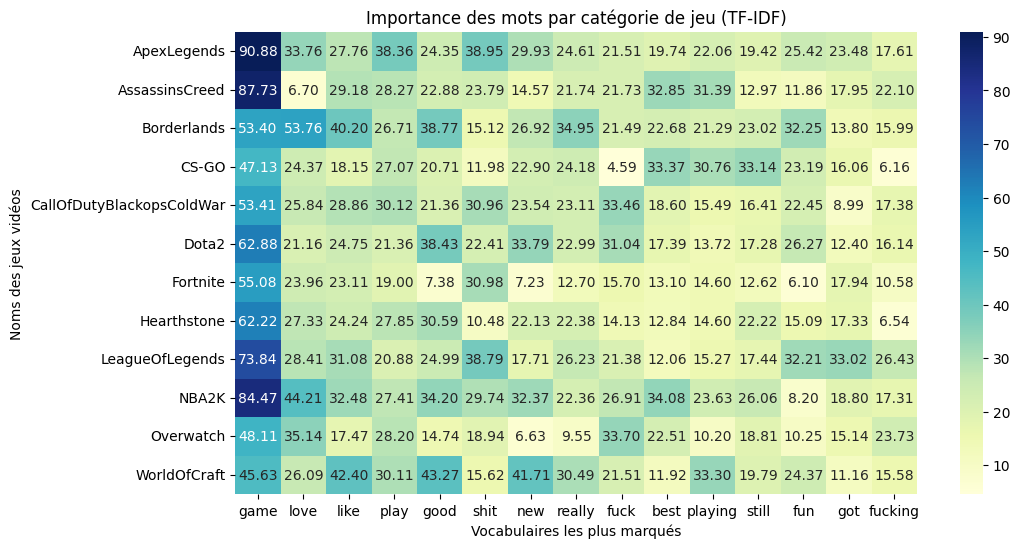

In [37]:
tfidf_matrix = pd.DataFrame(X_train_vec.toarray(), columns=vectorizer.get_feature_names_out())

# Ajouter la colonne `game_category` au TF-IDF matrix
tfidf_matrix['game_category'] = df['game_category']

# Étape 2 : Agrégation par jeu
tfidf_grouped = tfidf_matrix.groupby('game_category').sum()

# Étape 3 : Sélection des mots les plus importants (optionnel)
top_words = tfidf_grouped.sum(axis=0).sort_values(ascending=False).head(15).index
tfidf_grouped_top = tfidf_grouped[top_words]

# Étape 4 : Création de la heatmap
plt.figure(figsize=(11, 6))
sns.heatmap(tfidf_grouped_top, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Importance des mots par catégorie de jeu (TF-IDF)")
plt.xlabel("Vocabulaires les plus marqués")
plt.savefig("Best_Vocabulary_sentimental_by_game.png")
plt.ylabel("Noms des jeux vidéos")
plt.show()

## Entrainement et choix des modèles de Machine Learning

#### Procédure d'Encodage des catégories de sentiments

In [38]:
# Encodage des catégories
sentiments = LabelEncoder()
df['sentiment_category_encoded'] = sentiments.fit_transform(df['sentiment_category'])
y = df['sentiment_category_encoded']

### Validation croisée pour déterminer la meilleure performance du modèle
Derniers relevés pour le choix du modèle:

Logistic Regression <br>
Cross-validation scores: [0.57, 0.57, 0.53, 0.52, 0.6] <br>
Mean cross-validation score: 0.56 <br>
Test score: 0.81 <br>

Random Forest <br>
Cross-validation scores: [0.58, 0.56, 0.52, 0.53, 0.61] <br>
Mean cross-validation score: 0.56  <br>
Test score: 0.95 <br>

MultinomialNB
Cross-validation scores: [0.59, 0.58, 0.52, 0.53, 0.6] <br>
Mean cross-validation score: 0.57 <br>
Test score: 0.77 <br>

In [39]:
# Initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "MultinomialNB": MultinomialNB()
}

# Train and evaluate classifiers with cross-validation
for clf_name, clf in classifiers.items():
    print(clf_name)
    # Perform cross-validation
    cv_scores = cross_val_score(clf, X_train_vec, y_train, cv=5, scoring="accuracy")
    # Convertir en floats natifs et arrondir à 2 décimales
    cv_scores_rounded = [round(float(score), 2) for score in cv_scores]  
    print(f"Cross-validation scores: {cv_scores_rounded}")
    print(f"Mean cross-validation score: {round(float(cv_scores.mean()), 2)}")  # Arrondir la moyenne

    # Fit the classifier on the entire training set
    clf.fit(X_train_vec, y_train)

    # Evaluate the classifier on the test set
    test_score = clf.score(X_val_vec, y_val)
    print(f"Test score: {round(float(test_score), 2)}\n")  # Arrondir le score test

Logistic Regression
Cross-validation scores: [0.57, 0.58, 0.56, 0.57, 0.6]
Mean cross-validation score: 0.58
Test score: 0.8

Random Forest
Cross-validation scores: [0.58, 0.58, 0.58, 0.58, 0.61]
Mean cross-validation score: 0.59
Test score: 0.95

MultinomialNB
Cross-validation scores: [0.59, 0.6, 0.56, 0.57, 0.6]
Mean cross-validation score: 0.58
Test score: 0.77



### Validation croisée alternée par RandomizedSearchCV pour déterminer les meilleurs hyperparamètres

In [40]:
# Définir les hyperparamètres à tester
param_distributions = {
    'n_estimators': randint(100, 200),  # Distribution pour le nombre d'arbres
    'max_depth': [None, 6],            # Valeurs fixes possibles
    'min_samples_split': randint(2, 4),  # Distribution pour le nombre minimal d'échantillons
    'min_samples_leaf': randint(1, 3)    # Distribution pour les feuilles
}

# Instanciation du modèle
rf_model = RandomForestClassifier()

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=10,                 # Nombre d'échantillons aléatoires à tester
    scoring='accuracy',        # Métrique d'évaluation sur l'accuracy
    cv=5,                      # Validation croisée avec 5 folds
    random_state=42,           # Pour la reproductibilité
    n_jobs=2                   # Utilisation de 2 coeurs
)

# Entraînement de RandomizedSearchCV
random_search.fit(X_train_vec, y_train)

# Obtenir les meilleurs paramètres et le meilleur score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", round(best_score,2))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 186}
Best Score: 0.59


### Evaluation du modèle pour le jeu de validation

In [41]:
# Modèle
model = RandomForestClassifier(**best_params)
model.fit(X_train_vec, y_train)

# Prédictions
y_pred = model.predict(X_val_vec)

### Performance des Modèles de Classification

#### **Négatif**
| Métrique                | Valeur |
|-------------------------|--------|
| **Vrais positifs (TP)** | 169    |
| **Faux positifs (FP)**  | 13     |
| **Faux négatifs (FN)**  | 15     |
| **Précision**           | 0.928  |
| **Rappel**              | 0.918  |

**Calculs:**
- Précision: (169 / (169 + 13)) = 0.928
- Rappel: (169 / (169 + 15)) = 0.918

#### **Neutre**
| Métrique                | Valeur |
|-------------------------|--------|
| **Vrais positifs (TP)** | 156    |
| **Faux positifs (FP)**  | 8      |
| **Faux négatifs (FN)**  | 23     |
| **Précision**           | 0.951  |
| **Rappel**              | 0.871  |

**Calculs:**
- Précision: (156 / (156 + 8)) = 0.951
- Rappel: (156 / (156 + 23)) = 0.871

#### **Positif**
| Métrique                | Valeur |
|-------------------------|--------|
| **Vrais positifs (TP)** | 195    |
| **Faux positifs (FP)**  | 26     |
| **Faux négatifs (FN)**  | 9      |
| **Précision**           | 0.882  |
| **Rappel**              | 0.955  |

**Calculs:**
- Précision: (195 / (195 + 26)) = 0.882
- Rappel: (195 / (195 + 9)) = 0.955

#### **Accuracy Totale**

**Calcul:**
Accuracy = ((169 + 156 + 195) / ((169 + 13 + 15) + (156 + 8 + 23) + (195 + 26 + 9))) = 0.917

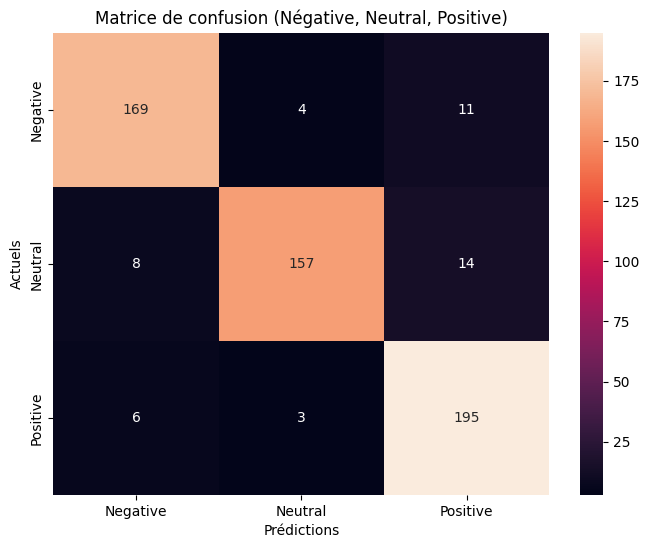

In [42]:
conf_mat = confusion_matrix(y_val, y_pred)
categories = ["Negative","Neutral","Positive"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=categories, yticklabels=categories)
plt.title("Matrice de confusion (Négative, Neutral, Positive)")
plt.xlabel("Prédictions")
plt.ylabel("Actuels")
plt.show()


On trouve ainsi un accuracy qui soit égal à 92% lorsqu'on fait la prédiction avec le jeu de validation



In [43]:
# Rapport de classification
print(classification_report(y_val, y_pred, target_names=sentiments.classes_))

              precision    recall  f1-score   support

    Negative       0.92      0.92      0.92       184
     Neutral       0.96      0.88      0.92       179
    Positive       0.89      0.96      0.92       204

    accuracy                           0.92       567
   macro avg       0.92      0.92      0.92       567
weighted avg       0.92      0.92      0.92       567



In [44]:
df_val["prediction_sentiment"] = model.predict(X_val_vec)
df_val.head()

,game_category,sentiment_category,Tweet,tweet_clean,prediction_sentiment
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hacking truly awf...,Negative
5,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,hi madeleine mccann cellar past year little sn...,Negative
6,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...,thank new te austin hooper orange brown pic tw...,Positive
7,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ...",rocket league sea thief rainbow six siege love...,Positive
8,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...,still knee deep assassin creed odyssey way any...,Positive


### Visualisation des résultats prédits et réelles

In [45]:
nb_actual_sent = df_val['sentiment_category'].value_counts()
nb_pred_sent = df_val['prediction_sentiment'].value_counts()

print(nb_actual_sent)
print(nb_pred_sent)

sentiment_category
Positive    204
Negative    184
Neutral     179
Name: count, dtype: int64
prediction_sentiment
Positive    220
Negative    183
Neutral     164
Name: count, dtype: int64


### Comparaison au total des sentiments réelles vs prédits

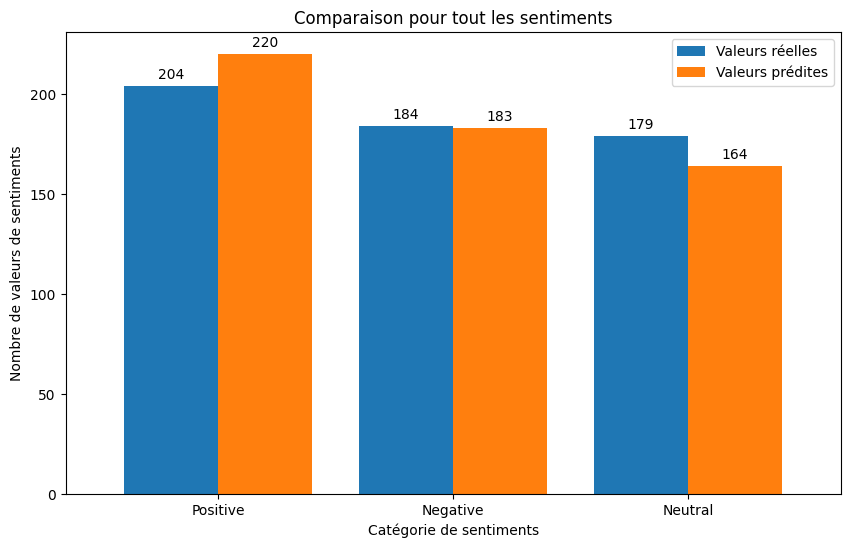

In [46]:
# Comptage des valeurs réelles et des valeurs prédites
df_comparison = pd.concat([nb_actual_sent,nb_pred_sent], axis=1)

# Créer le graphique avec des barres groupées
ax = df_comparison.plot(kind='bar', width=0.8, figsize=(10, 6))

# Ajouter des labels et un titre
plt.title('Comparaison pour tout les sentiments')
plt.xlabel('Catégorie de sentiments')
plt.ylabel('Nombre de valeurs de sentiments')
plt.xticks(rotation=0)

# Ajouter les valeurs au-dessus des barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)
plt.legend(['Valeurs réelles', 'Valeurs prédites'], loc='upper right')
plt.show()

In [108]:
real_sentiments = df_val.groupby(['game_category', 'sentiment_category']).size().unstack(fill_value=0)
predicted_sentiments = df_val.groupby(['game_category', 'prediction_sentiment']).size().unstack(fill_value=0)
combined_sentiments = real_sentiments.join(predicted_sentiments, lsuffix='_real', rsuffix='_predicted').reset_index()

In [109]:
combined_sentiments.head()

,game_category,Negative_real,Neutral_real,Positive_real,Negative_predicted,Neutral_predicted,Positive_predicted
0,ApexLegends,6,17,10,6,17,10
1,AssassinsCreed,4,4,24,4,3,25
2,Battlefield,7,4,3,7,4,3
3,Borderlands,5,12,14,7,11,13
4,CS-GO,2,13,9,2,12,10


### Répartition des sentiments (Negative, Neutral, Positive) pour chaque type de jeu dans l'ordre alphabétique

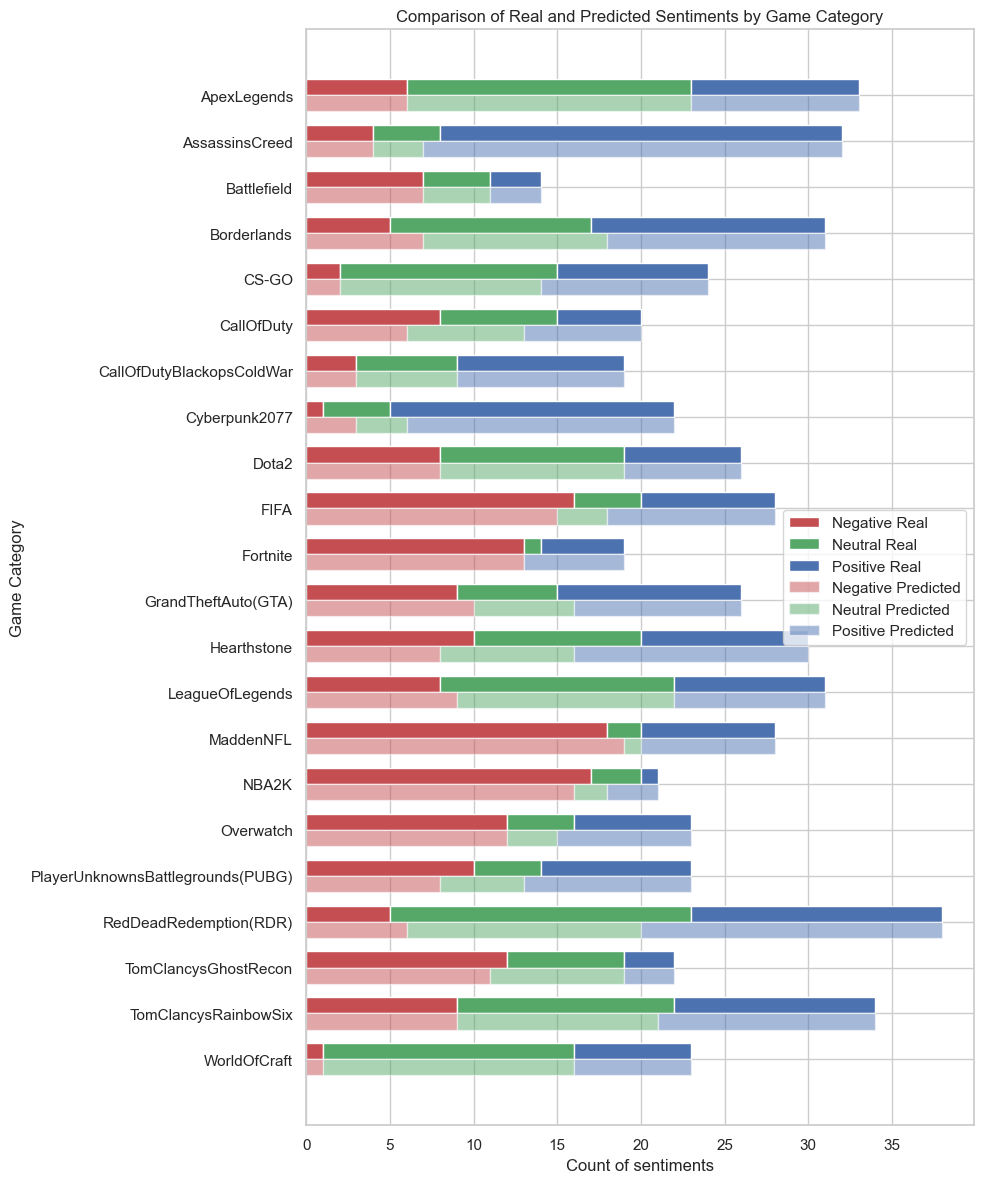

In [114]:
# Configuration du graphique
combined_sentiments = combined_sentiments.sort_values(by='game_category', ascending=False)

categories = combined_sentiments['game_category']
y = np.arange(len(categories)) 
height = 0.35

fig, ax = plt.subplots(figsize=(10, 12))

ax.barh(y + height/2, combined_sentiments['Negative_real'], height, label='Negative Real', color='r')
ax.barh(y + height/2, combined_sentiments['Neutral_real'], height, left=combined_sentiments['Negative_real'], label='Neutral Real', color='g')
ax.barh(y + height/2, combined_sentiments['Positive_real'], height, left=combined_sentiments['Negative_real']+combined_sentiments['Neutral_real'], label='Positive Real', color='b')

ax.barh(y - height/2, combined_sentiments['Negative_predicted'], height, label='Negative Predicted', color='r', alpha=0.5)
ax.barh(y - height/2, combined_sentiments['Neutral_predicted'], height, left=combined_sentiments['Negative_predicted'], label='Neutral Predicted', color='g', alpha=0.5)
ax.barh(y - height/2, combined_sentiments['Positive_predicted'], height, left=combined_sentiments['Negative_predicted']+combined_sentiments['Neutral_predicted'], label='Positive Predicted', color='b', alpha=0.5)

# Ajout des labels, titre et légende
ax.set_xlabel('Count of sentiments')
ax.set_ylabel('Game Category')
ax.set_title('Comparison of Real and Predicted Sentiments by Game Category')
ax.set_yticks(y)
ax.set_yticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()